In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def getImage():
    cam = cv.VideoCapture(0)
    ret, frame = cam.read()
    cam.release()
    if ret:
        return frame
    else:
        return None

In [9]:
# get the image
img = getImage()
# create an image of shape = image.shape without color channels
blank_img = np.zeros(img.shape[:2], dtype=np.uint8)
# draw a circle on this blank image of white color
blank_img_circle = cv.circle(blank_img, (200,200), 100, 255, 10)
# perform bitwise_and of image with itself and pass through the circle image
result = cv.bitwise_and(img, img, mask = blank_img_circle)

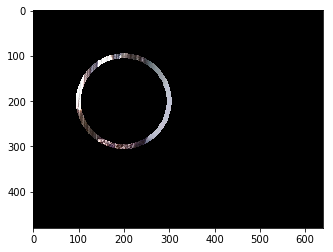

In [10]:
plt.imshow(result)

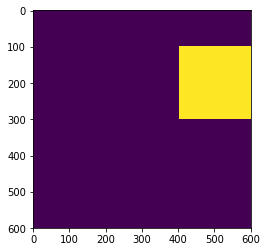

In [31]:
roi_top = 100
roi_bottom = 300
roi_left = 400
roi_right = 600

im = np.zeros(shape=(600, 600), dtype='uint8')
# plt.imshow(cv.rectangle(im, (roi_left, roi_top), (roi_right, roi_bottom), 255, 10))
im[roi_top:roi_bottom, roi_right:roi_left:-1] = 255
plt.imshow(im)

In [84]:
from sklearn.metrics import pairwise

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


background = None

roi_top = 100
roi_bottom = 300
roi_left = 400
roi_right = 600

In [3]:
def calAverageBackground(newFrame, accumulated_weight):
    
    global background
    
    if background is None:
        background = newFrame.copy().astype('float')
        return None
    
    cv.accumulateWeighted(newFrame, background, accumulated_weight)

In [4]:
cap = cv.VideoCapture(0)

nFrames = 0

while True:
    ret, frame = cap.read()
    roi = frame[roi_top:roi_bottom, roi_left:roi_right]
    gray = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
    gray = cv.GaussianBlur(gray, (7,7), 0)
    calAverageBackground(gray, 0.5)
    if nFrames>60:
        break
    nFrames+=1
cap.release()

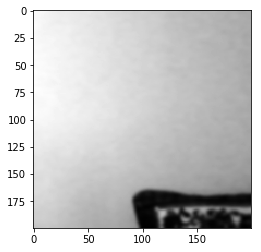

In [5]:
plt.imshow(background, cmap='gray')

In [6]:
cap = cv.VideoCapture(0)

nFrames = 0

while True:
    ret, frame = cap.read()
    roi = frame[roi_top:roi_bottom, roi_left:roi_right]
    gray = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
    gray = cv.GaussianBlur(gray, (7,7), 0)
    if nFrames>60:
        break
    nFrames+=1
cap.release()

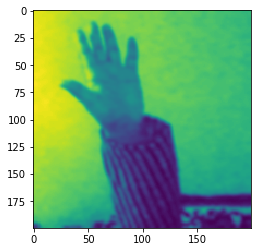

In [7]:
plt.imshow(gray)

In [8]:
diff = cv.absdiff(background.astype('uint8'), gray)

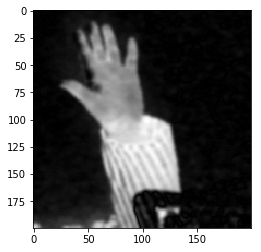

In [9]:
plt.imshow(diff, cmap='gray')

In [18]:
ret, thresh = cv.threshold(diff, 35, 255, cv.THRESH_BINARY)

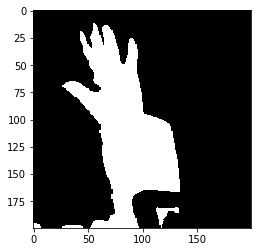

In [20]:
plt.imshow(thresh, cmap='gray')

In [21]:
image, contours, hierarchy = cv.findContours(thresh,
                                             cv.RETR_EXTERNAL,
                                             cv.CHAIN_APPROX_SIMPLE)

In [22]:
len(contours)

4

In [35]:
blank_img = np.zeros(image.shape, dtype=np.uint8)
handSegement = max(contours, key=cv.contourArea)

In [50]:
external_contour = cv.drawContours(blank_img, handSegement, -1, 255, 2)

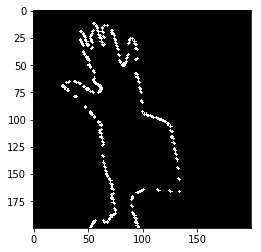

In [51]:
plt.imshow(external_contour, cmap='gray')

In [100]:
hull = cv.convexHull(handSegement)

In [101]:
hull

array([[[134, 166]],

       [[ 96, 199]],

       [[ 52, 199]],

       [[ 27,  70]],

       [[ 27,  69]],

       [[ 43,  19]],

       [[ 55,  12]],

       [[ 56,  12]],

       [[ 68,  14]],

       [[ 91,  26]],

       [[ 93,  28]],

       [[126, 106]],

       [[127, 111]],

       [[132, 137]],

       [[133, 145]],

       [[134, 155]]], dtype=int32)

In [109]:
smallest_Y_valued_pair_index = hull[:, :, 1].argmin()
largest_Y_valued_pair_index = hull[:, :, 1].argmax()
smallest_X_valued_pair_index = hull[:, :, 0].argmin()
largest_X_valued_pair_index = hull[:, :, 0].argmax()
    
    # using that index we grab the desired least or most valued coordinate
topMost = tuple(hull[smallest_Y_valued_pair_index][0])
bottomMost = tuple(hull[largest_Y_valued_pair_index][0])
leftMost = tuple(hull[smallest_X_valued_pair_index][0])
rightMost = tuple(hull[largest_X_valued_pair_index][0])
    
    # index 1 grabs y-coordinate and index 0 grabs x-coordinate
    # considering that the center of palm is
    # halfway between leftMost and rightMost point
    # and 
    # halfway between topMost and bottomMost point
    
xCenter = (leftMost[0] + rightMost[0]) // 2
yCenter = (topMost[1] + bottomMost[1]) // 2
center = (xCenter, yCenter)

In [114]:
distances = pairwise.euclidean_distances(X=[center], Y=[leftMost, rightMost, topMost, bottomMost])[0]

In [115]:
distances

array([63.51377803, 81.46778504, 96.30160954, 95.35197953])

In [230]:
radius = int(0.8*distances.max())
circumference = (2*np.pi*radius)

In [231]:
circle_roi = np.zeros(thresh.shape, dtype='uint8')
circle_roi = cv.circle(circle_roi, (xCenter, yCenter), radius, 255, 25)
circle_roi = cv.bitwise_and(thresh, thresh, mask=circle_roi)

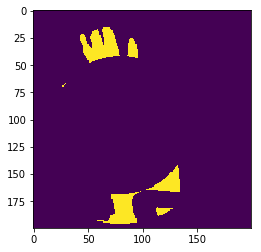

In [232]:
plt.imshow(circle_roi)

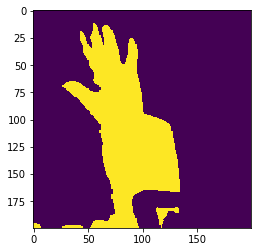

In [222]:
plt.imshow(thresh)

In [223]:
kernel = np.ones((5,5), dtype=np.uint8)
eroded_img = cv.erode(circle_roi.copy(), kernel, iterations = 1)

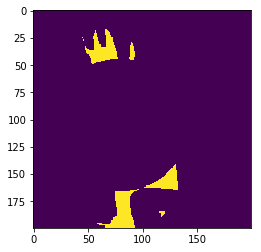

In [235]:
plt.imshow(eroded_img)

In [184]:
image, contours, hierarchy = cv.findContours(eroded_img,
                                             cv.RETR_EXTERNAL,
                                             cv.CHAIN_APPROX_NONE)

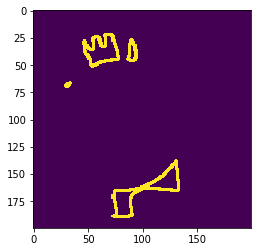

In [185]:
blank = np.zeros(thresh.shape, dtype='uint8')
plt.imshow(cv.drawContours(blank, contours, -1, 255, 2))

In [247]:
len(contours)

4

In [252]:
(x,y,w,h) = cv.boundingRect(contours[1])

In [245]:
i = cv.rectangle(eroded_img, (x,y), (x+w, y+h), 255, 3)

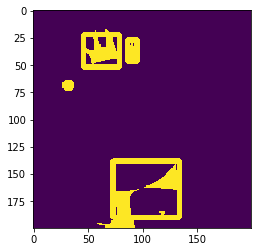

In [246]:
plt.imshow(i)

In [248]:
yCenter

105

In [251]:
y+h

190

In [253]:
#thumb
y+h

71

In [256]:
contours[0].shape

(190, 1, 2)

In [258]:
circumference*0.25

120.95131716320704

In [259]:
contours[0]

array([[[130, 138]],

       [[130, 139]],

       [[129, 140]],

       [[128, 141]],

       [[127, 142]],

       [[127, 143]],

       [[126, 144]],

       [[125, 145]],

       [[124, 146]],

       [[123, 147]],

       [[122, 148]],

       [[121, 149]],

       [[120, 150]],

       [[119, 151]],

       [[118, 152]],

       [[117, 152]],

       [[116, 153]],

       [[115, 154]],

       [[114, 155]],

       [[113, 155]],

       [[112, 156]],

       [[111, 157]],

       [[110, 157]],

       [[109, 158]],

       [[108, 158]],

       [[107, 159]],

       [[106, 159]],

       [[105, 160]],

       [[104, 160]],

       [[103, 161]],

       [[102, 161]],

       [[101, 162]],

       [[100, 162]],

       [[ 99, 162]],

       [[ 98, 163]],

       [[ 97, 163]],

       [[ 96, 163]],

       [[ 95, 163]],

       [[ 94, 164]],

       [[ 93, 164]],

       [[ 92, 164]],

       [[ 91, 164]],

       [[ 90, 164]],

       [[ 89, 164]],

       [[ 88, 165]],

       [[ 

In [56]:
b = np.zeros(shape=(64,64), dtype=np.int64)
w = np.zeros(shape=(64,64), dtype=np.int64)
m = np.zeros(shape=(64,64), dtype=np.uint8)

In [57]:
b[10:20, 10:20] = 255
w[10:30, 10:30] = 255

In [25]:
bw = cv.bitwise_and(w,w,mask=b)

error: OpenCV(3.4.2) C:\projects\opencv-python\opencv\modules\core\src\arithm.cpp:241: error: (-215:Assertion failed) (mtype == 0 || mtype == 1) && _mask.sameSize(*psrc1) in function 'cv::binary_op'


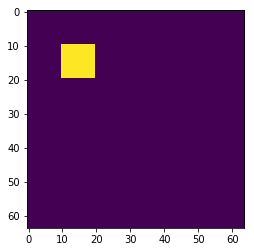

In [39]:
plt.imshow(cv.bitwise_and(w,b))

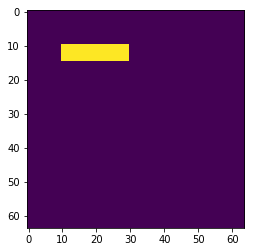

In [59]:
plt.imshow(cv.bitwise_or(w,b,mask=m))

In [58]:
m[10:15,:] = 255